In [58]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 24, 'font.family': 'Helvetica', 'text.usetex': False})
%matplotlib inline

from utils.models import MLP
from utils.trainer import train_MLP
from utils.data import create_xor_dataset
from utils.plotting import plot_var, plot_task_rep, plot_hidden_in, plot_hidden_out
from utils.constants import COLORS

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


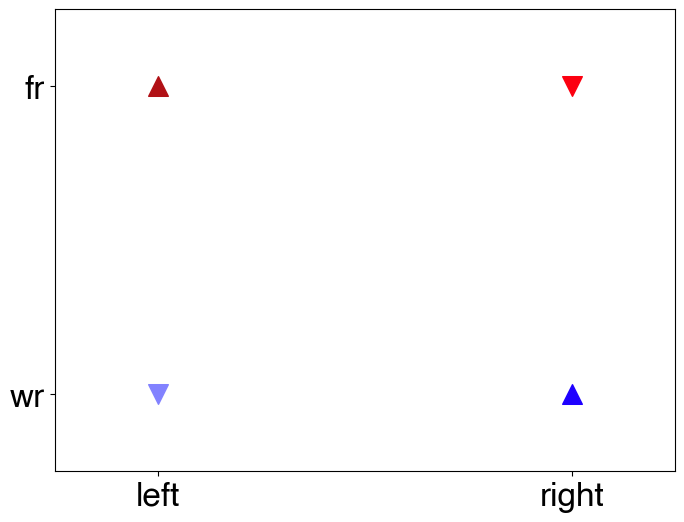

In [51]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y_np  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

X, y = create_xor_dataset(x1, x2, y_np, n_repeats=1, noise_lev=0)

fig, ax = plot_task_rep(X, y, colors=[COLORS['left_wr'], COLORS['left_fr'], COLORS['right_wr'], COLORS['right_fr']])
# ax.set_xlim([-2.5, 2.5])
# ax.set_ylim([-2.5, 2.5])
fig.set_size_inches((8, 6))
# fig.savefig("noisy_inputs.svg")

In [52]:
n_runs = 20
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (1, -1)

lr = 2e-3  # Learning rate
# Initialization scale
w1_inits = [0.0025, 0.25]
w2_init = 1/dim_hidden

models = []
losses = np.zeros((len(w1_inits), n_runs, n_epochs))
w1_rel_changes = np.zeros((len(w1_inits), n_runs, n_epochs))
w2_rel_changes = np.zeros((len(w1_inits), n_runs, n_epochs))

# Training
for w_i, w1_init in enumerate(w1_inits):
    for r_i in range(n_runs):
        # Model instantiation
        dlnn_model = MLP(dim_input, dim_hidden, dim_output, w1_init, w2_init)
    
        loss_per_run, weight_rel_changes_per_run = train_MLP(dlnn_model, X, y, n_epochs=n_epochs, lr=lr, noise_lev=0.5)
        losses[w_i, r_i, :] = loss_per_run
        w1_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[0]
        w2_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[1]

    models.append(dlnn_model)

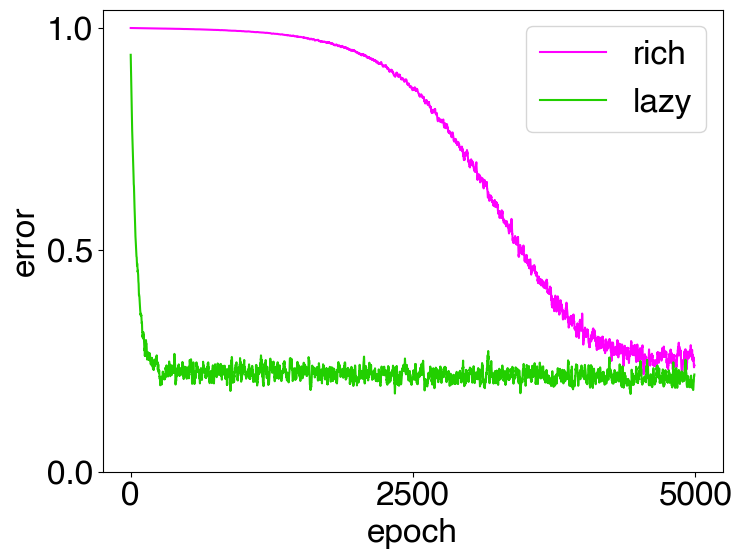

In [77]:
fig, ax = plot_var(losses, running_avg=10, y_ticks=[0, 0.5, 1], fig_size=(8, 6))
fig.savefig("noisy_training_loss.svg")

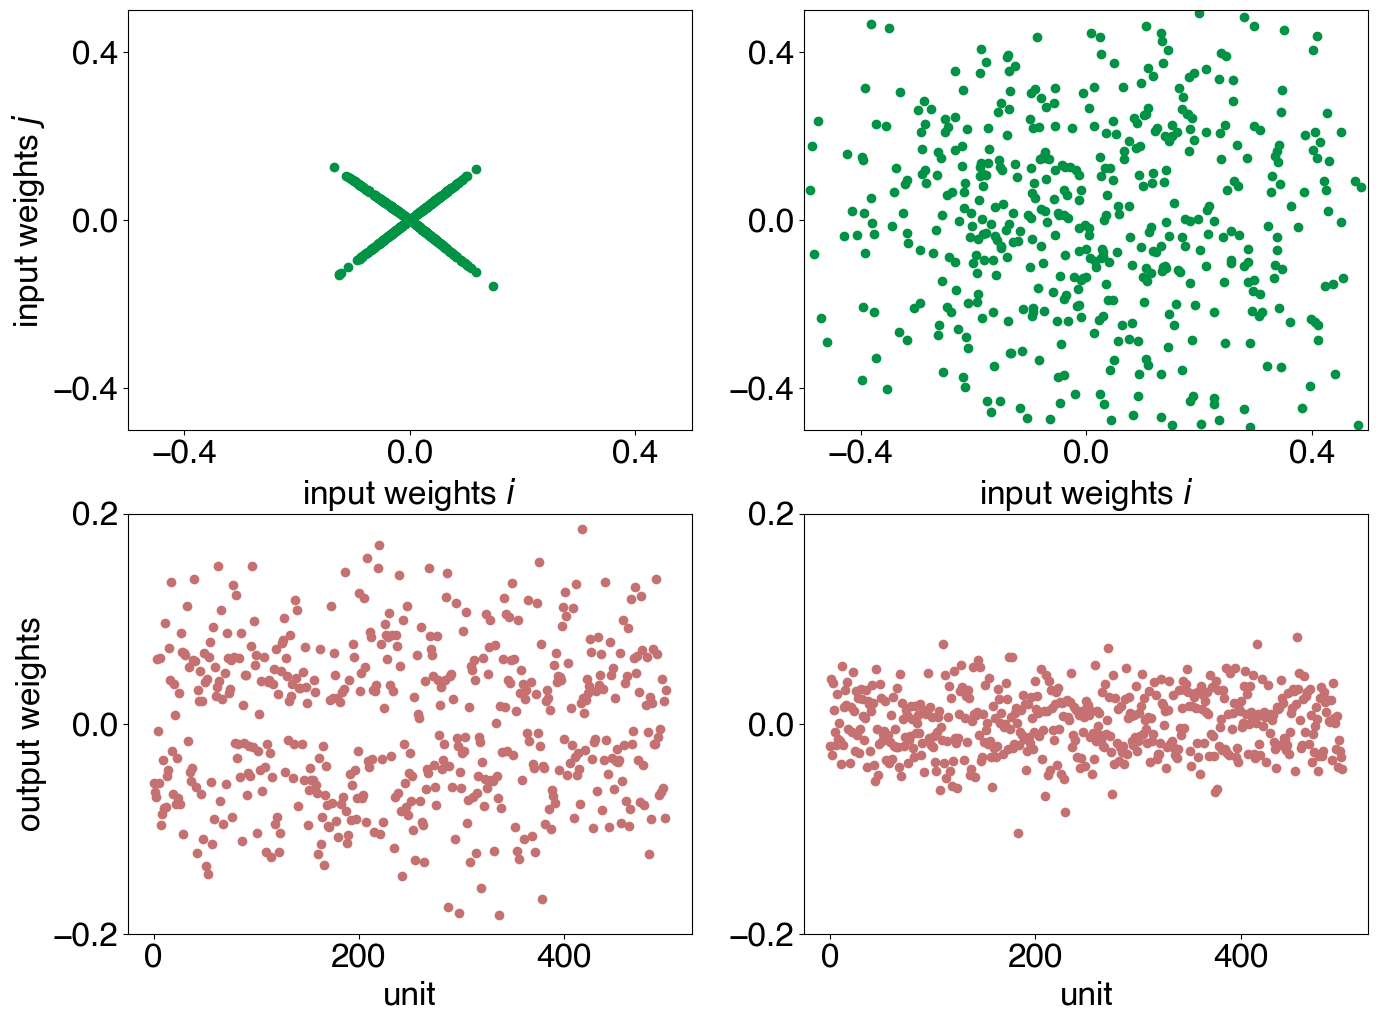

In [62]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 12)

for m_i, model in enumerate(models):
    for p_i, (name, param) in enumerate(model.named_parameters()):
        axis = axes[p_i, m_i]
        
        if name == 'in_hid.weight':
            in_hid = param.detach().numpy()
            axis = plot_hidden_in(in_hid, axis)

        elif name == 'hid_out.weight':
            hid_out = param.detach().numpy()
            axis = plot_hidden_out(hid_out, axis)

        if m_i != 0:
            axis.set_ylabel(None)

# plt.savefig("noisy_rich_lazy_learning.svg")